# Unobserved components model with stochastic volatility - particle filter fit

Hopefully better than MCMC

# 1. Read data

In [1]:
import pandas as pd
from seminartools.data import read_inflation

df = read_inflation()
df

,Country Code,IMF Country Code,Country,yearmonth,inflation
8537,ESP,184,Spain,1970-04-01,0.000000
11635,GTM,258,Guatemala,1970-04-01,0.012577
1231,AUS,193,Australia,1970-04-01,0.011236
7708,DOM,243,Dominican Republic,1970-04-01,-0.001604
21697,NZL,196,New Zealand,1970-04-01,0.015421
...,...,...,...,...,...
16098,KOR,542,"Korea, Rep.",2023-01-01,0.010538
15095,JPN,158,Japan,2023-01-01,0.004500
14347,ITA,136,Italy,2023-01-01,0.003938
21470,NOR,142,Norway,2023-01-01,0.006886


/tmp/ipykernel_989836/2129217928.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_df["pi"] = (1 + country_df["inflation"]).cumprod()


<Axes: xlabel='yearmonth'>

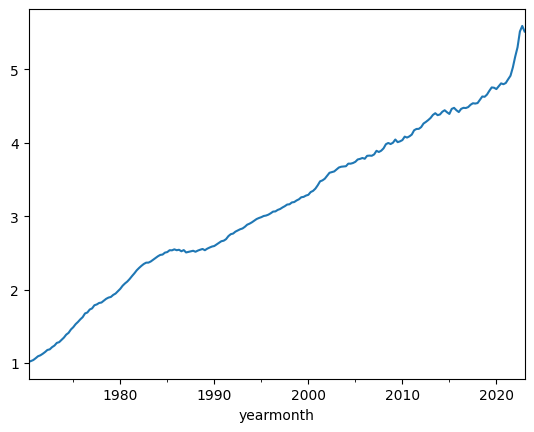

In [2]:
country_df = df[df["Country"] == "Netherlands"]
country_df["pi"] = (1 + country_df["inflation"]).cumprod()
country_df.set_index("yearmonth")["pi"].plot()

In [3]:
len(country_df)

212

# 2. Construct PF

$\pi_t = \tau_t + \eta_t$

$\tau_t = \tau_{t-1} + \epsilon_t$

$\ln \sigma_{\eta,t}^2 = \ln \sigma_{\eta,t-1}^2 + \nu_{\eta, t}$

$\ln \sigma_{\epsilon,t}^2 = \ln \sigma_{\epsilon,t-1}^2 + \nu_{\epsilon, t}$

In [46]:
import scipy
import numpy as np
from seminartools.models.base_model import BaseModel
from tqdm import trange

# nu follows a normal distribution with variance gamma
GAMMA = 0.2

INIT_LNSETASQ = -8
INIT_LNSEPSILONSQ = -8

# Unobserved Component Stochastic Volatility Particle Filter
class UCSVPF(BaseModel):
    def __init__(
        self,
        num_particles: int,
    ):
        self.num_particles = num_particles

    def fit(self, data: pd.DataFrame):
        """
        This model is not meant to be fitted to data every iteration using this method.
        Preferably, fit once on the entire dataset using `run_pf` and then
        figure out the historical predictions using the historical particles.
        """
        pass

    def run_pf(self, data: pd.DataFrame):
        """
        Run the particle filter on the data.
        """
        n = len(data)

        pi = data["pi"].values

        # [tau, lnsetasq, lnsepsilonsq]

        # Particles
        X0 = np.zeros((self.num_particles, 3))
        # Tau
        # Variance of tau_0 is epsilon[0]
        X0[:, 0] = np.random.normal(size=self.num_particles, loc=1, scale=np.sqrt(
            np.exp(INIT_LNSEPSILONSQ)
        ))
        # lnsetasq
        # Variance of lnsetasq is gamma
        X0[:, 1] = np.random.normal(
            size=self.num_particles, loc=INIT_LNSETASQ, scale=np.sqrt(GAMMA)
        )
        # lnsepsilonsq
        # Variance of lnsepsilonsq is gamma
        X0[:, 2] = np.random.normal(
            size=self.num_particles, loc=INIT_LNSEPSILONSQ, scale=np.sqrt(GAMMA)
        )

        # Weights
        W0 = np.zeros(self.num_particles)
        # Weight corresponds to the PDF of the normal distribution
        # with mean 1 and variance sigma_eta^2 
        W0 = scipy.stats.norm.pdf(X0[:, 0], loc=1, scale=np.sqrt(np.exp(INIT_LNSEPSILONSQ)))
        # Normalize
        W0 = W0 / np.sum(W0)

        # History of particles and weights
        X = np.zeros((n + 1, self.num_particles, 3))
        W = np.zeros((n + 1, self.num_particles))
        X[0, :, :] = X0
        W[0, :] = W0

        # The first observation in the data corresponds
        # to t=1.
        for t in trange(1, n + 1):
            # Step 1: resample
            indices = np.random.choice(
                self.num_particles, size=self.num_particles, replace=True, p=W[t - 1, :]
            )
            X[t, :, :] = X[t - 1, indices, :]
            # Reset W after resampling
            W[t, :] = np.ones(self.num_particles) / self.num_particles

            # Step 2: update step
            for i in range(self.num_particles):
                # tau follows a random walk with variance exp(lnsepilonsq) (index 2)
                X[t, i, 0] = np.random.normal(loc = X[t, i, 0], scale = np.sqrt(np.exp(X[t, i, 2])))
                # lnsetasq follows a random walk with variance gamma
                X[t, i, 1] = np.random.normal(loc = X[t, i, 1], scale = np.sqrt(GAMMA))
                # lnsepsilonsq follows a random walk with variance gamma
                X[t, i, 2] = np.random.normal(loc = X[t, i, 2], scale = np.sqrt(GAMMA))

                # Calculate the weights
                # Random normal PDF of observation pi[t-1] (pi was shifted by 1)
                # with mean tau[t] (index 0)
                # and variance exp(lnsetasq) (index 1)
                W[t, i] *= scipy.stats.norm.pdf(pi[t-1], loc = X[t, i, 0], scale = np.sqrt(np.exp(X[t, i, 1])))

            # Normalize the weights
            W[t, :] = W[t, :] / np.sum(W[t, :])

        self.X = X[1:, :, :] # Remove t=0
        self.W = W[1:, :]
        self.EX = np.mean(self.X, axis=1) # Take mean along the particle dimension
        self.Meff = np.zeros(n)
        for t in range(0, n):
            self.Meff[t - 1] = 1 / np.sum(self.W[t, :] ** 2)

    def predict(self, data: pd.DataFrame) -> pd.Series:
        """
        Predict the state at time t.
        """
        pass

model = UCSVPF(num_particles=1000)
model.run_pf(country_df)


            


100%|██████████| 212/212 [00:12<00:00, 16.77it/s]


In [47]:
country_df["pi"]

21046    1.014768
21047    1.026581
21048    1.040367
21049    1.064980
21050    1.091895
           ...   
21253    5.172314
21254    5.300400
21255    5.515166
21256    5.591137
21257    5.514721
Name: pi, Length: 212, dtype: float64

In [48]:
model.EX.shape

(212, 3)

<Axes: xlabel='yearmonth'>

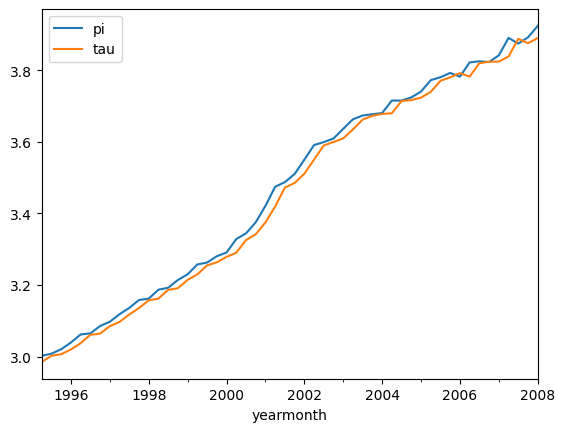

In [58]:
merged = pd.concat(
    [
        country_df["pi"].reset_index(drop=True),
        pd.DataFrame(model.EX, columns=["tau", "lnsetasq", "lnsepsilonsq"]),
    ],
    axis = 1
).set_index(country_df["yearmonth"])
merged[["pi", "tau"]].iloc[100:152].plot()

<Axes: xlabel='yearmonth'>

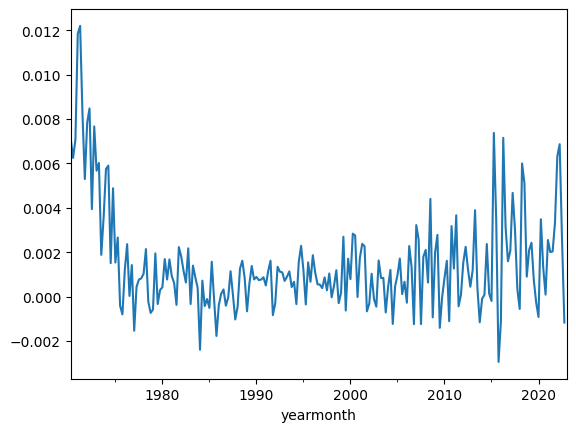

In [59]:
(merged["pi"] - merged["tau"].shift(-1)).plot()

(3.875368451091027, 4.752620975707903)

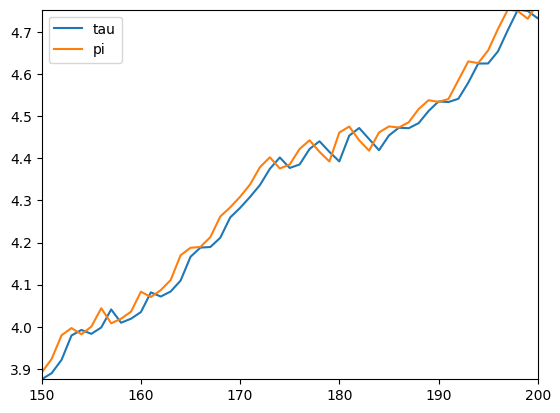

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(model.EX).iloc[:, 0].plot(label = "tau")
country_df["pi"].reset_index(drop = True).plot(label = "pi")
plt.legend()
plt.xlim(150, 200)
plt.ylim(model.EX[150:200, 0].min(), model.EX[150:200, 0].max())

<Axes: xlabel='yearmonth'>

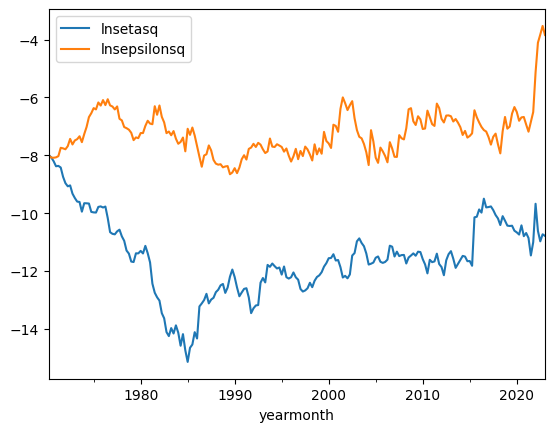

In [61]:
merged[["lnsetasq", "lnsepsilonsq"]].plot()

<Axes: xlabel='yearmonth'>

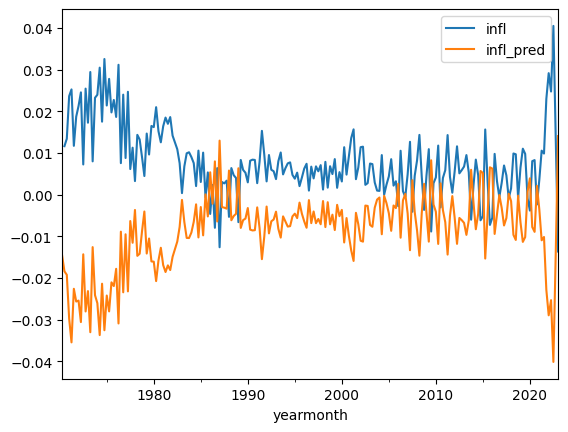

In [64]:
merged["infl_pred"] = (merged["tau"] / merged["pi"]) - 1
merged["infl"] = merged["pi"].pct_change()
merged[["infl", "infl_pred"]].plot()

hmm something went wrong.